In [1]:
import os
import sys
import pickle
import json
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from multiprocessing import Pool
from pyquaternion import Quaternion

import torch

In [2]:
sys.path.append('/home/wit/Drive/Workspace/ApolloScape_InstanceSeg/lib')
from datasets import car_models

In [3]:
%matplotlib inline

scale = 1.8
plt.rcParams['figure.figsize'] = [6.4*scale, 4.8*scale]
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [71]:
output_dpath = '../output/json_test_trans_iou_0.5_BBOX_AUG_multiple_scale_CAR_CLS_AUG_multiple_scale/'
#output_dpath = '../output/json_test_trans_iou_0.5_BBOX_AUG_single_scale_CAR_CLS_AUG_single_scale/'

img_fnames = [fname[:-5] for fname in os.listdir(output_dpath)]

intrinsic_mat = np.array([[2.30454787e+03, 0.00000000e+00, 1.68623788e+03],
       [0.00000000e+00, 2.30587567e+03, 1.35498486e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

#### Visualization

In [72]:
def euler_to_quaternion(rot_pred):
    bank, heading, attitude = rot_pred

    import math
    c1 = math.cos(heading/2)
    c2 = math.cos(attitude/2)
    c3 = math.cos(bank/2)

    s1 = math.sin(heading/2)
    s2 = math.sin(attitude/2)
    s3 = math.sin(bank/2)

    w = (c1 * c2 * c3) - (s1 * s2 * s3)
    x = (s1 * s2 * c3) + (c1 * c2 * s3)
    y = (s1 * c2 * c3) + (c1 * s2 * s3)
    z = (c1 * s2 * c3) - (s1 * c2 * s3)

    return w, x, -y, z

In [73]:
def remove_redundant_preds(preds):
    preds = sorted(preds, key=lambda x: x['score'], reverse=True)

    area_th = 5000
    overlap_th = 0.75

    masks = []
    indices =[]
    for i, pred in enumerate(preds):
        rot_pred = np.array(pred['pose'][:3])
        trans_pred = np.array(pred['pose'][3:])
        cls_pred = pred['car_id']
        score_pred = pred['score']

        car_model_fpath = os.path.join('../peku/train',
                                       'car_models_json',
                                       car_models.models[cls_pred].name+'.json')
        f = open(car_model_fpath, 'r')
        data = f.read()
        f.close()

        car = json.loads(data)
        car['vertices'] = np.array(car['vertices'])
        car['faces'] = np.array(car['faces'])
        car['vertices'][:, [0, 1]] *= -1

        rot_mat = Quaternion(euler_to_quaternion(rot_pred)).rotation_matrix
        rvect, _ = cv2.Rodrigues(rot_mat)
        imgpts, jac = cv2.projectPoints(np.float32(car['vertices']),
                                        rvect,
                                        trans_pred,
                                        intrinsic_mat,
                                        distCoeffs=None)
        imgpts = np.int32(imgpts).reshape(-1, 2)

        mask = np.zeros((img.shape[0], img.shape[1]))
        for face in car['faces'] - 1:
            pts = np.array([[imgpts[f, 0], imgpts[f, 1]] for f in face], np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.drawContours(mask, [pts], 0, (255, 255, 255), -1)
        mask = mask > 250.0

        if mask.sum() <= area_th:
            continue

        is_found = False
        for ref_mask in masks:
            r1 = np.sum(mask & ref_mask) / np.sum(mask)
            r2 = np.sum(mask & ref_mask) / np.sum(ref_mask)
            if r1 >= overlap_th or r2 >= overlap_th:
                is_found = True
                break
        if is_found:
            continue

        masks.append(mask)
        indices.append(i)

    preds = [preds[i] for i in indices]
    return preds

In [74]:
def inference_box_to_3dxyz(preds):
    fx = intrinsic_mat[0][0]
    fy = intrinsic_mat[1][1]
    cx = intrinsic_mat[0][2]
    cy = intrinsic_mat[1][2]

    inf_preds = []
    for i, pred in enumerate(preds):
        rot_pred = np.array(pred['pose'][:3])
        trans_pred = np.array(pred['pose'][3:])
        cls_pred = pred['car_id']
        score_pred = pred['score']

        car_model_fpath = os.path.join('../peku/train',
                                       'car_models_json',
                                       car_models.models[cls_pred].name+'.json')
        f = open(car_model_fpath, 'r')
        data = f.read()
        f.close()

        car = json.loads(data)
        car['vertices'] = np.array(car['vertices'])
        car['faces'] = np.array(car['faces'])
        car['vertices'][:, [0, 1]] *= -1

        rot_mat = Quaternion(euler_to_quaternion(rot_pred)).rotation_matrix

        box_pred = np.array(pred['box'])
        xc = ((box_pred[0] + box_pred[2]) / 2 - cx) / fx
        yc = ((box_pred[1] + box_pred[3]) / 2 - cy) / fy
        ymax = (box_pred[3] - cy) / fy

        x_y_z_R = np.matmul(rot_mat, np.transpose(np.float32(car['vertices'])))
        Rymax = x_y_z_R[1, :].max()
        Rxc = x_y_z_R[0, :].mean()
        Ryc = x_y_z_R[1, :].mean()
        Rzc = x_y_z_R[2, :].mean()
        zc = (Ryc - Rymax) / (yc - ymax)

        xt = zc * xc - Rxc
        yt = zc * yc - Ryc
        zt = zc - Rzc

        inf_pred = pred.copy()
        inf_pred['pose'][3:] = xt, yt, zt
        inf_preds.append(inf_pred)

    return inf_preds

In [75]:
instance_id = 0

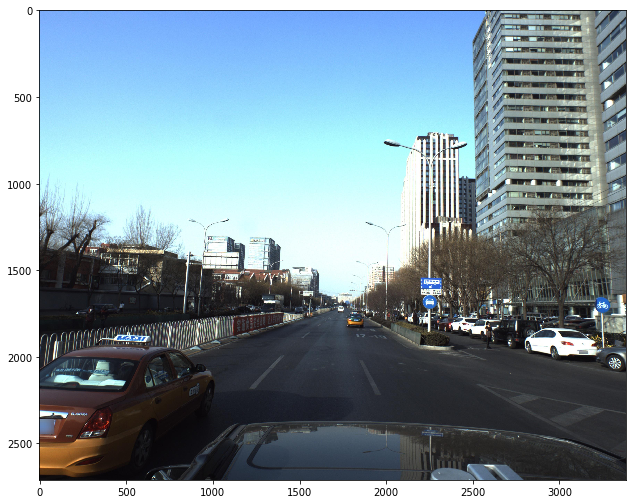

In [76]:
fname = img_fnames[instance_id]
img = cv2.imread('../peku/test/images/' + fname + '.jpg')
plt.imshow(img[:, :, ::-1])

In [77]:
img_fname = img_fnames[instance_id]
with open(output_dpath + img_fname + '.json') as f:
    preds = json.load(f)

In [78]:
preds = inference_box_to_3dxyz(preds)
preds = remove_redundant_preds(preds)

In [81]:
rot_preds = []
trans_preds = []
cls_preds = []
score_preds = []
box_preds = []
for p in preds:
    rot_preds.append(p['pose'][:3])
    trans_preds.append(p['pose'][3:])
    cls_preds.append(p['car_id'])
    score_preds.append(p['score'])
    box_preds.append(p['box'])

rot_preds = np.array(rot_preds)
trans_preds = np.array(trans_preds)
cls_preds = np.array(cls_preds)
score_preds = np.array(score_preds)
box_preds = np.array(box_preds)

In [83]:
pred_id = 0

rot_pred = rot_preds[pred_id]
trans_pred = trans_preds[pred_id]
cls_pred = cls_preds[pred_id]
box_pred = box_preds[pred_id]

In [84]:
car_model_fpath = os.path.join('../peku/train', 'car_models_json', car_models.models[cls_pred].name+'.json')
f = open(car_model_fpath, 'r')
data = f.read()
f.close()

car = json.loads(data)
car['vertices'] = np.array(car['vertices'])
car['faces'] = np.array(car['faces'])
car['vertices'][:, [0, 1]] *= -1

In [85]:
rot_mat = Quaternion(euler_to_quaternion(rot_pred)).rotation_matrix
rvect, _ = cv2.Rodrigues(rot_mat)
imgpts, jac = cv2.projectPoints(np.float32(car['vertices']), rvect, trans_pred, intrinsic_mat, distCoeffs=None)
imgpts = np.int32(imgpts).reshape(-1, 2)

In [86]:
mask = np.zeros((img.shape[0], img.shape[1]))
for face in car['faces'] - 1:
    pts = np.array([[imgpts[f, 0], imgpts[f, 1]] for f in face], np.int32)
    pts = pts.reshape((-1, 1, 2))
    #cv2.polylines(mask, [pts], True, (255, 255, 255))
    cv2.drawContours(mask, [pts], 0, (255, 255, 255), -1)

In [ ]:
ex_mask = mask[:, :, None].repeat(3, axis=2).astype(np.bool)

np_img = img.copy()
np_img[ex_mask] = 0

cv2.rectangle(np_img, tuple(box_pred[0:2]), tuple(box_pred[2:4]), (0, 204, 0), 10)

plt.imshow(np_img[:, :, ::-1])

In [88]:
box_pred

array([2784, 1839, 3217, 2020])

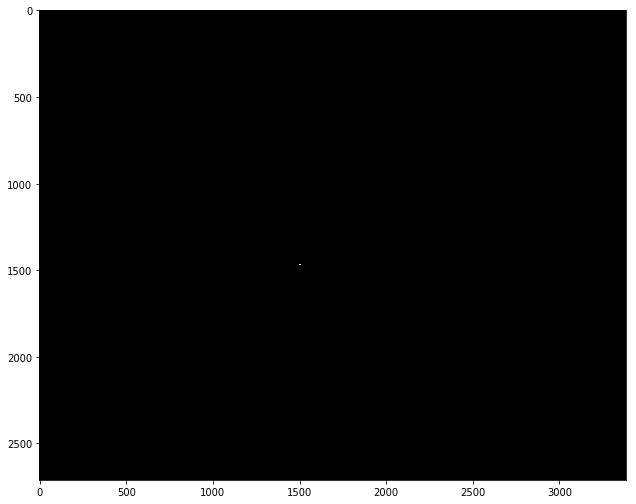

In [293]:
plt.imshow(ex_mask[:, :, 0])

In [159]:
intrinsic_mat

array([2304.54786557, 2305.87566806, 1686.23787613, 1354.9848644 ])

In [134]:
rot_pred, trans_pred

(array([ 0.02790694, -0.01237206, -0.08611811, -0.9958171 ], dtype=float32),
 array([ 7.579524,  8.46892 , 30.339027], dtype=float32))

In [124]:
img.shape

(2710, 3384, 3)

#### Generate a submission file

In [63]:
img_fnames = pd.read_csv('../peku/sample_submission.csv')['ImageId'].values

output_dpath = '../output/'
json_dname = 'json_test_trans_iou_0.5_BBOX_AUG_multiple_scale_CAR_CLS_AUG_multiple_scale/'
#json_dname = 'json_test_trans_iou_0.5_BBOX_AUG_single_scale_CAR_CLS_AUG_single_scale/'

In [65]:
def get_pred_str(img_fname):
    pred_str = img_fname + ','
    try:
        with open(output_dpath + json_dname + img_fname + '.json') as f:
            preds = json.load(f)
    except FileNotFoundError:
        return pred_str

    preds = inference_box_to_3dxyz(preds)
    preds = remove_redundant_preds(preds)

    for pred in preds:
        roll, pitch, yaw, x, y, z = pred['pose']
        score = pred['score']

        pred_str += f'{roll} {pitch} {yaw} {x} {y} {z} {score} '

    return pred_str.strip()

In [66]:
pool = Pool(8)
results = pool.map(get_pred_str, img_fnames)

out = open(os.path.join(output_dpath, 'submission.csv'), 'w')
out.write('ImageId,PredictionString\n')
out.write('\n'.join(results))
out.close()

In [120]:
pred.get_field('trans_pred')

tensor([[ 0.1284, 10.5649, 53.0486]])

In [119]:
pred.get_field('rot_pred')

[0.0, 0.0, 0.0, 0.0]

In [118]:
pred.get_field('rot_pred')

[0.0, 0.0, 0.0, 0.0]

In [105]:
preds[16].fields()

['cls_score', 'cls', 'rot_pred', 'trans_pred']

In [106]:
idx = 16

In [ ]:
preds[16]

In [113]:
pred = preds[16]

In [114]:
pred.get_field('scores')

KeyError: 'scores'

In [115]:
pred.get_field('rot_pred')

[0.0, 0.0, 0.0, 0.0]

In [116]:
pred.get_field('trans_pred')

tensor([[ 0.1284, 10.5649, 53.0486]])